## MVP Know Your Transaction (KYT) - Transaction Risk Classification Engine

### Project Overview

This notebook presents a comprehensive implementation of a Transaction Risk Classification Engine for Anti-Money Laundering (AML) compliance in cryptocurrency transactions. The project addresses the critical need for risk assessment of Bitcoin transactions by combining traditional AML indicators with blockchain-specific risk factors.

### Domain Context: Financial AML for Transactions

#### Core Domain Definition
Anti-Money Laundering (AML) for transactions encompasses the comprehensive framework of laws, regulations, procedures, and technological solutions designed to prevent criminals from disguising illegally obtained funds as legitimate income through the global financial system. This domain includes detection, prevention, and reporting of money laundering, terrorist financing, tax evasion, market manipulation, and misuse of public funds.

### Problem Definition: Transaction Risk Classification Engine

#### Problem Statement
Develop a system that assigns risk classifications to cryptocurrency transactions in real-time, integrating traditional AML indicators with blockchain-specific risk factors including wallet clustering, transaction graph analysis, and counterparty reputation scoring.

#### Technical Requirements
- **Problem Type**: Classification 
- **Processing Speed**: Sub-second analysis for high-frequency transactions
- **Difficulty Level**: High - requires complex multi-dimensional data processing
- **Output Format**: Risk binary classification (illicit = 1 /licit = 2)

#### Data Landscape
The system can processes multiple data dimensions:
- Transaction metadata (amounts, timestamps, fees)
- Wallet addresses and clustering information
- Transaction graph relationships and network topology
- Counterparty databases and reputation scores
- Sanctions lists and regulatory databases
- Temporal patterns and behavioral baselines

### References

This notebook implementation is based on the comprehensive research and analysis conducted during the project development phase. The following reference documents were used in the composition of this initial description:

- **Domain Research**: [current-domain.md](domains/current-domain.md) - Contains detailed market analysis, regulatory framework research, and commercial viability assessment for the Financial AML domain;
- **Problem Analysis**: [current-problem.md](problems/current-problem.md) - Provides comprehensive problem refinement, technical requirements analysis, and solution approach evaluation;
- **Dataset Evaluation**: [current-dataset.md](datasets/current-dataset.md) - Documents dataset selection criteria, suitability scoring, and detailed feature analysis for the Elliptic dataset;
- **Dataset Analysis & Preprocessing**: [dataset-analysis-and-preprocessing.ipynb](datasets/scripts/dataset-analysis-and-preprocessing.ipynb) - Comprehensive Jupyter notebook containing Elliptic dataset download, exploratory data analysis, and ML preparation steps;

These reference documents contain the foundational research that informed the technical approach, feature engineering strategy, and implementation decisions reflected in this notebook.

---

This notebook serves as the primary entry point for the MVP KYT implementation and it can run independently, providing both technical implementation and business context for real cryptocurrency transaction risk assessment.

### Import Libraries

Comprehensive installation and import of all required libraries for machine learning procedures.

In [ ]:
%pip install pytorch-tabnet scikeras tensorflow
%pip install xgboost lightgbm catboost
%pip install azure-storage-blob optuna
%pip install kaleido

#Colab setup only
!git clone https://github.com/zzaia/zzaia-mvp-kyt-pos.git
%cd zzaia-mvp-kyt-pos

import warnings
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
import tensorflow as tf
import optuna
from PIL import Image
import io
import kaleido

# Add datasets/scripts to Python path
scripts_path = Path("./datasets/scripts")
if str(scripts_path.resolve()) not in sys.path:
    sys.path.insert(0, str(scripts_path.resolve()))

# Add models/scripts to Python path
models_scripts_path = Path("./models/scripts")
if str(models_scripts_path.resolve()) not in sys.path:
    sys.path.insert(0, str(models_scripts_path.resolve()))

# Import Azure utilities
from azure_utils import AzureBlobDownloader
azureClient = AzureBlobDownloader("https://stmvppos.blob.core.windows.net", "mvpkytsup")

# Suppress all warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
tf.get_logger().setLevel('ERROR')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

### Loading pre-processed datasets

Let's load the pre-processed and compressed data from remote and local sources. The dataset is a composition of cryptocurrency transactions in the Bitcoin blockchain. 

It has 166 features, of which 92 features represent local transaction information and another 72 features represent aggregated information from one-hop neighboring transactions (directly linked transactions). Thus, the dataset already has curated information about the relationships between transactions. 

This is very important because money laundering and fraud patterns often involve coordinated transaction clusters and neighborhood patterns.

In [2]:
# Define paths
dataset_dir = Path("elliptic_bitcoin_dataset")
root_dir = Path("./datasets")
processed_dir = root_dir / "processed" / dataset_dir
root_dir.mkdir(exist_ok=True)

# Download processed data from Azure if not present locally
if not processed_dir.exists() or not any(processed_dir.iterdir()):
    print(f"Local processed directory is empty. Downloading from Azure...")
    azureClient.download_documents("datasets/processed", dataset_dir.name, base_path="./")

# The complete dataset already pre-processed 
df_complete = pd.read_hdf(processed_dir / "df_complete.h5", key="df_complete")
print(f"Loaded from HDF5: {df_complete.shape} - All subsequent operations will use compressed data")

# The filtered labeled dataset already pre-processed
df_labeled = pd.read_hdf(processed_dir / "df_labeled.h5", key="df_labeled")
print(f"Loaded from HDF5: {df_labeled.shape} - All subsequent operations will use compressed data")

# The filtered unlabeled dataset already pre-processed
df_unlabeled = pd.read_hdf(processed_dir / "df_unlabeled.h5", key="df_unlabeled")
print(f"Loaded from HDF5: {df_unlabeled.shape} - All subsequent operations will use compressed data")

# The edges dataset that maps relationships between transaction nodes
df_edges = pd.read_hdf(processed_dir / "df_edges.h5", key="df_edges")
print(f"Loaded from HDF5: {df_edges.shape} - All subsequent operations will use compressed data")

# Summary of all datasets
print(f"\n📊 Dataset Summary:")
print(f"  - Features: {df_complete.shape[0]:,} transactions × {df_complete.shape[1] -2} features")
print(f"  - Labeled: {df_labeled.shape[0]:,} transactions")
print(f"  - Unlabeled: {df_unlabeled.shape[0]:,} transactions")
print(f"  - Edges: {df_edges.shape[0]:,} transaction relationships")

Local processed directory is empty. Downloading from Azure...
Successfully downloaded 4 files from Azure Blob Storage
Loaded from HDF5: (203769, 168) - All subsequent operations will use compressed data
Loaded from HDF5: (46564, 168) - All subsequent operations will use compressed data
Loaded from HDF5: (157205, 168) - All subsequent operations will use compressed data
Loaded from HDF5: (234355, 2) - All subsequent operations will use compressed data

📊 Dataset Summary:
  - Features: 203,769 transactions × 166 features
  - Labeled: 46,564 transactions
  - Unlabeled: 157,205 transactions
  - Edges: 234,355 transaction relationships


### Machine Learning Strategy

Let's apply machine learning techniques to the labeled dataset portion using supervised learning, and apply the prediction to the unknown unlabeled dataset portion in order to establish a performance baseline for future improvements.

Following these steps:

1. Define overall parameters and make data splits;
2. Define all training models to be used;
3. Define all pipelines to be used during training;
4. Define model parameter distributions for a grid search approach;
5. Define the score function to be used during training;
6. Execute the training;
7. Save all resulting models;
8. Validate all models and select the best models;
9. Use best models to predict unknown data;

**1. Define overall parameters and make data splits**

After splitting the labeled dataset into training and validation (test) sets, let's prepare the training dataset for training and validation using the stratified approach, which generates a fixed number of splits (folds) for the dataset following a fixed proportion of train/test samples. 

The main idea of this approach is to guarantee training without bias toward a specific dataset split because it maintains the same class proportion for each split (fold) generated. We use this technique in labeled and supervised learning, assuming that the dataset's pattern does not have significant changes over time.

In this specific dataset, we consider the timestamp as a grouping factor for transactions but not as a changing factor for the dataset's pattern over time.

In [3]:
# Defining overall parameters
random_seed = 4354 # PARAMETER: random seed
test_size_split = 0.20 # PARAMETER: test set size
n_stratified_splits = 2 # PARAMETER: number of folds
n_pca_components = 0.95 # PARAMETER: PCA components to keep

np.random.seed(random_seed)

# Prepare data
x_labeled = df_labeled.drop(['class', 'txId'], axis=1)
y_labeled = df_labeled['class']

# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(x_labeled, y_labeled,
    test_size=test_size_split, 
    shuffle=True, 
    random_state=random_seed, 
    stratify=y_labeled) # stratified holdout

# Cross-validation setup to be applied in the training set 
cv = StratifiedKFold(n_splits=n_stratified_splits, 
                     shuffle=True, 
                     random_state=random_seed)

**2. Define all models and pipelines to be used during training**

Let's define which ML pipelines to use during training, by configuring which pre-processing operations and models will be used in the training process. Pipelines also help avoid data leakage by ensuring that feature transformation is applied only to the training dataset portion.          

For feature transformation, the standard scaler was used to ensure the best scale for feature values. By normalizing all values to a common metric, it reduces bias toward feature magnitude and enables subsequent operations to capture important patterns between features without being influenced mainly by their magnitude. All features contribute equally to pattern detection. This is especially important in finance because the difference between feature scales can be significant.

For feature dimensionality reduction, Principal Component Analysis (PCA) was used to reduce from 166 to only 59 features. We aim to reduce feature dimensionality while maximizing the dissimilarity of the original dataset, thus extracting the most discriminative features and improving model training performance. It must be applied after the standard scaler to avoid the mentioned magnitude bias, and should be used in datasets that have a large quantity of features.

In [4]:
# Import pipeline wrappers
from lr_wrapper import LRWrapper
from knn_wrapper import KNNWrapper
from cart_wrapper import CARTWrapper
from nb_wrapper import NBWrapper
from svm_wrapper import SVMWrapper
from bagging_wrapper import BaggingWrapper
from voting_soft_wrapper import VotingSoftWrapper
from rf_wrapper import RFWrapper
from et_wrapper import ETWrapper
from ada_wrapper import AdaWrapper
from gb_wrapper import GBWrapper
from stacking_wrapper import StackingWrapper
from stacking_adv_wrapper import StackingAdvWrapper
from bag_knn_wrapper import BagKNNWrapper
from xgboost_wrapper import XGBoostWrapper
from lightgbm_wrapper import LightGBMWrapper
from catboost_wrapper import CatBoostWrapper
from histgb_wrapper import HistGBWrapper
from tabnet_wrapper import TabNetWrapper
from fnn_wrapper import FNNWrapper

# Create pipeline wrapper instances
pipeline_wrappers = []
# Uncomment models as needed for training
pipeline_wrappers.append(LRWrapper(random_seed=random_seed))
pipeline_wrappers.append(NBWrapper(random_seed=random_seed))
pipeline_wrappers.append(KNNWrapper(random_seed=random_seed))
pipeline_wrappers.append(CARTWrapper(random_seed=random_seed))
pipeline_wrappers.append(SVMWrapper(random_seed=random_seed))
pipeline_wrappers.append(BaggingWrapper(random_seed=random_seed))
pipeline_wrappers.append(VotingSoftWrapper(random_seed=random_seed))
pipeline_wrappers.append(RFWrapper(random_seed=random_seed))
pipeline_wrappers.append(ETWrapper(random_seed=random_seed))
pipeline_wrappers.append(AdaWrapper(random_seed=random_seed))
pipeline_wrappers.append(GBWrapper(random_seed=random_seed))
pipeline_wrappers.append(StackingWrapper(random_seed=random_seed))
pipeline_wrappers.append(StackingAdvWrapper(random_seed=random_seed))
pipeline_wrappers.append(BagKNNWrapper(random_seed=random_seed))
pipeline_wrappers.append(XGBoostWrapper(random_seed=random_seed))
pipeline_wrappers.append(LightGBMWrapper(random_seed=random_seed))
pipeline_wrappers.append(CatBoostWrapper(random_seed=random_seed))
pipeline_wrappers.append(HistGBWrapper(random_seed=random_seed))
pipeline_wrappers.append(TabNetWrapper(random_seed=random_seed))
pipeline_wrappers.append(FNNWrapper(random_seed=random_seed))

print(f"📦 Loaded {len(pipeline_wrappers)} pipeline wrappers")

📦 Loaded 20 pipeline wrappers


**3. Define model parameter distributions for a grid search approach**

Let's prepare the parameter distributions for a random grid search, by using a distribution of possible parameter values, so that the training phase can explore the best performance models also from the perspective of their hyperparameters. This is a better solution than the common grid search approach because it can explore a broader hyperparameter space and is often faster. 

Three types of parameter distributions were used:

- uniform: Continuous values with equal probability across a range, used when all values in the range are equally valid;
- loguniform: Continuous values on logarithmic scale (exponential distribution), used when smaller values are often better;
- randint: Discrete integer values with equal probability, used for discrete hyperparameters.

In [5]:
# Build parameter distributions from wrappers
param_distributions = {}
for wrapper in pipeline_wrappers:
    param_distributions[wrapper.name] = wrapper.get_param_distributions()

print(f"📊 Parameter distributions loaded for {len(param_distributions)} models")


📊 Parameter distributions loaded for 20 models


**4. Define the score function and the objective function to be used during training**

Let's define the score function that will be used to measure each model's performance. Instead of using just one metric alone, the function enables us to define a weighted multi-metric approach, defining which metrics would be more important for the model's performance. The chosen score is a combination of three important metrics: 

- MCC measures how balanced the model is at classifications by considering all confusion matrix metrics;
- PR-AUC measures precision and recall at all thresholds, says how model is good to generate true positives independent o tunning;
- Cost measures how costly the training result is based on a business oriented metric;   

In financial transaction risk assessments, it is more important to have fewer false negatives than false positive classifications, because it would be less risky to block a transaction wrongly considered illicit than to not block a transaction wrongly considered licit.

In [6]:
from aml_scorer import AMLScorer

# Instantiate scorer
aml_scorer = AMLScorer(cost_fp=1, cost_fn=10, cost_tn=0, cost_tp=0, mcc_weight=0.3, cost_weight=0.2, prauc_weight=0.5)

# Create sklearn scorer
composite_scorer = make_scorer(aml_scorer.score)

# Print metric equation
print("📊 AML Scoring Metric:")
print("-" * 70)
print(aml_scorer.metric_equation)
print("-" * 70)

📊 AML Scoring Metric:
----------------------------------------------------------------------
AML Score = 0.3 × MCC + 0.2 × Cost Score + 0.5 × PR-AUC

Components:
  MCC (Matthews Correlation Coefficient):
    - Threshold-dependent: Evaluates classification quality at specific threshold
    - Measures: Correlation between predictions and actuals using all 4 confusion matrix values
    - Range: -1 (worst) to +1 (perfect), 0 = random
    - Key strength: Balanced metric, reliable for imbalanced data

  Cost Score:
    - Threshold-dependent: Business impact at specific threshold
    - Measures: Financial cost of classification errors
    - Formula: 1 - Total Cost / Max Cost
    - Total Cost = TN × 0 + TP × 0 + FP × 1 + FN × 10
    - Key strength: Incorporates asymmetric business costs (FN >> FP)

  PR-AUC (Precision-Recall Area Under Curve):
    - Threshold-independent: Evaluates performance across ALL thresholds
    - Measures: Model's discriminative ability and probability calibration qual

**5. Execute the training** 

Let's execute the training phase using Bayesian Optimization and execute it in parallel, with cross-validation of all dataset splits (folds) and rank the best models by score and objective function.

The final plot will display all model training samples with their mean and variance performance during training.

In [7]:
# Import training manager
from training_manager import TrainingManager

# Training parameters
n_trials = 200 # PARAMETER: number of hyperparameter trials per model
n_jobs = 1 
patience_ratio = 0.2 # PARAMETER: early stopping patience ratio
timeout_seconds = 2 * 60 * 60 # PARAMETER: 2 hours 
checkpoint_dir = Path("./models/mvp-kyt-sup-main")

# Create training manager
training_manager = TrainingManager(
    checkpoint_dir=checkpoint_dir,
    n_trials=n_trials,
    patience_ratio=patience_ratio,
    timeout_seconds=timeout_seconds,
    n_jobs=n_jobs,
    random_seed=random_seed
)


[TRAINING CAN BE SKIPPED > 2h]

🔍 Training 20 models (patience=40, timeout=2.0h)
Checkpoints: models/mvp-kyt-sup-main
------------------------------------------------------------
Loading checkpoint LR... ✅ 0.9464 (±0.0018) [65/200] is timed out: False]
Loading checkpoint NB... ✅ 0.7427 (±0.0039) [162/200] is timed out: False]
Loading checkpoint KNN... ✅ 0.9434 (±0.0018) [69/200] is timed out: False]
Loading checkpoint CART... ✅ 0.9205 (±0.0021) [62/200] is timed out: False]
Loading checkpoint SVM... ✅ 0.9627 (±0.0016) [178/200] is timed out: False]
Loading checkpoint Bag... ✅ 0.9488 (±0.0034) [52/200] is timed out: True]
Loading checkpoint Vote-Soft... ✅ 0.9622 (±0.0016) [122/200] is timed out: False]
Loading checkpoint RF... ✅ 0.9513 (±0.0015) [46/200] is timed out: True]
Loading checkpoint ET... ✅ 0.9558 (±0.0004) [200/200] is timed out: False]
Loading checkpoint Ada... ✅ 0.9171 (±0.0036) [124/200] is timed out: False]
Loading checkpoint GB... ✅ 0.9541 (±0.0013) [33/200] is timed out: True]
Loading checkpoint Stack

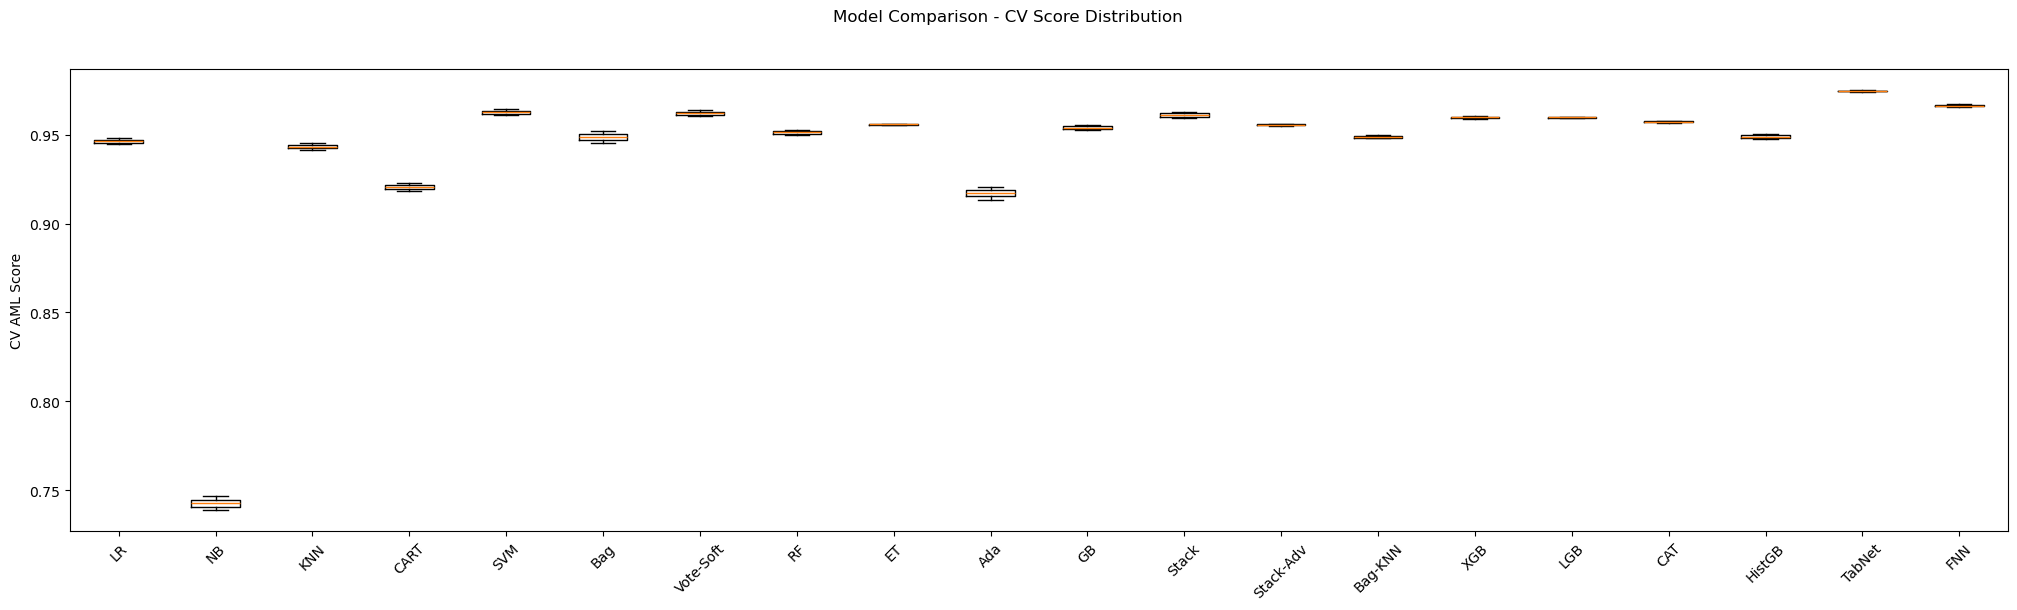

In [ ]:
# Train models
trained_models = training_manager.train_models(
    pipeline_wrappers=pipeline_wrappers,
    param_distributions=param_distributions,
    X_train=X_train,
    y_train=y_train,
    cv=cv,
    scorer=composite_scorer,
    aml_scorer=aml_scorer,
    n_pca_components=n_pca_components,
    azure_client=azureClient
)

# Visualization
fig = plt.figure(figsize=(25,6))
fig.suptitle('Model Comparison - CV Score Distribution') 
ax = fig.add_subplot(111) 
plt.boxplot([cv_scores for _, cv_scores, _, _, _ in trained_models], labels=[name for name, _, _, _, _ in trained_models])
ax.set_ylabel('CV AML Score')
ax.tick_params(axis='x', rotation=45)
plt.show()

**6. Load all resulting models**

Retrieve previously trained models from local or remote sources.

In [ ]:
if not 'trained_models' in locals():
    trained_models = training_manager.load_models_from_checkpoint(
        azure_client=azureClient
    )
    print(f"💾 {len(trained_models)} models in {checkpoint_dir}")

**7. Validate all models and select the best models**

Let's validate and select the best models by applying all trained pipelines to the previously generated testing set using the multi-metric score function.    

Model validation with an unseen dataset during training can give us an approximate measure of how the model would perform in the real world.

In [9]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, average_precision_score

# Select best models based on composite score with optimized thresholds
test_results = []
for name, cv_scores, pipe, study, threshold in trained_models:
    # Generate predictions
    y_proba = pipe.predict_proba(X_test)[:, 1]  # Probability of illicit class
    y_pred = (y_proba >= threshold).astype(int)
        
    # Calculate PR-AUC (threshold-independent)
    prauc = average_precision_score(y_test, y_proba)
    
    # Calculate metrics
    composite_score = aml_scorer.score(y_test, y_pred, y_proba)
    mcc = matthews_corrcoef(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    test_results.append({
        'name': name,
        'threshold': threshold,
        'composite': composite_score,
        'mcc': mcc,
        'prauc': prauc,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp
    })

# Sort by composite score
test_results.sort(key=lambda x: x['composite'], reverse=True)

# Display results
print(f"\n🏆 Final Model Rankings:")
print('-'*95)
print(f"{'Model':<12} {'Threshold':<11} {'Composite':<11} {'MCC':<8} {'PR-AUC':<8} {'TN':<6} {'FP':<5} {'FN':<5} {'TP':<5}")
print('-'*95)
for result in test_results:
    threshold_str = 'N/A' if result['threshold'] is None else f"{result['threshold']:.3f}"
    print(f"{result['name']:<12} {threshold_str:<11} {result['composite']:>7.4f}    "
          f"{result['mcc']:>6.3f}  {result['prauc']:>6.4f}  "
          f"{result['tn']:<6} {result['fp']:<5} {result['fn']:<5} {result['tp']:<5}")




🏆 Final Model Rankings:
-----------------------------------------------------------------------------------------------
Model        Threshold   Composite   MCC      PR-AUC   TN     FP    FN    TP   
-----------------------------------------------------------------------------------------------
TabNet       0.237        0.9750     0.922  0.9990  818    91    35    8369 
FNN          0.392        0.9644     0.887  0.9981  743    166   13    8391 
Vote-Soft    0.438        0.9628     0.883  0.9975  756    153   31    8373 
SVM          0.385        0.9624     0.884  0.9963  761    148   35    8369 
Stack        0.504        0.9615     0.880  0.9975  765    144   46    8358 
LGB          0.716        0.9604     0.877  0.9975  763    146   49    8355 
Stack-Adv    0.581        0.9577     0.867  0.9966  720    189   19    8385 
XGB          0.840        0.9571     0.866  0.9978  750    159   53    8351 
ET           0.704        0.9550     0.859  0.9977  740    169   53    8351 
CAT       

**8. Selecting the best model**

In [10]:
# Store best model for downstream use
best_model_name = test_results[0]['name']
best_model = next(pipe for name, _, pipe, _, _ in trained_models if name == best_model_name)
optimal_threshold = test_results[0]['threshold']
print(f"\n✅ Best model: {best_model_name} (threshold={optimal_threshold:.3f})")


✅ Best model: TabNet (threshold=0.237)


**9. Optuna Optimization Analysis**

Visualize Optuna optimization history and parameter importance for each model.

📊 Optuna Optimization Analysis for best model
------------------------------------------------------------

TabNet - Best Score: 0.9747
Best Parameters: {'tabnet__n_d': 64, 'tabnet__n_a': 64, 'tabnet__n_steps': 3, 'tabnet__gamma': 1.0945496531841405, 'tabnet__lambda_sparse': 4.708957086886377e-06, 'tabnet__mask_type': 'entmax', 'threshold': 0.23669152857908912}


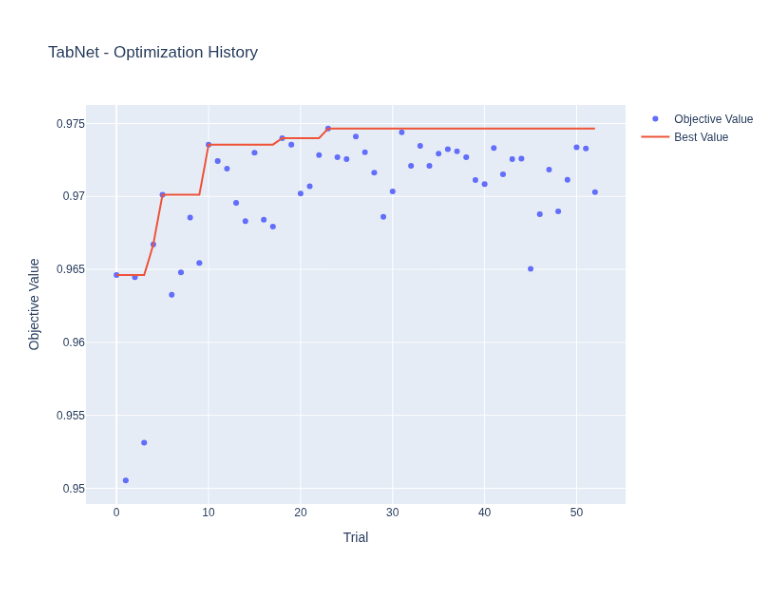

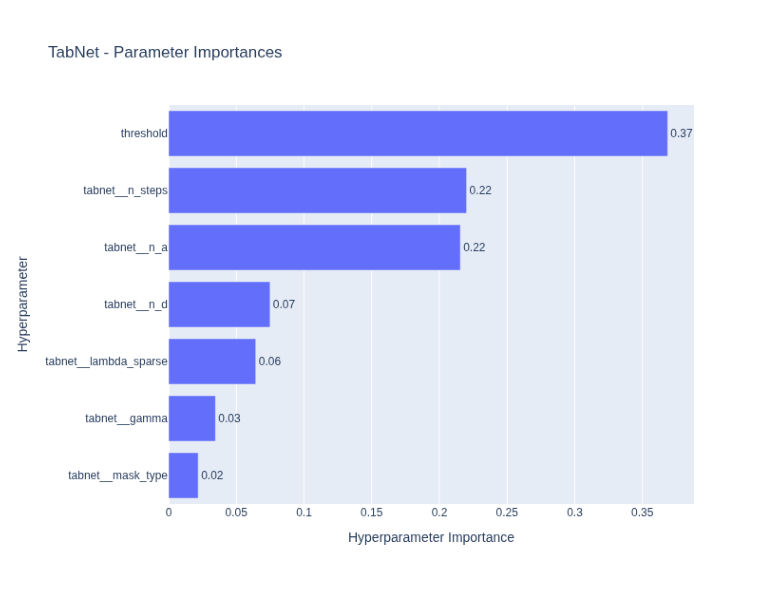

In [11]:
print("📊 Optuna Optimization Analysis for best model")
print("-" * 60)

# Extract study for best model
best_study = next(study for name, _, _, study, _ in trained_models if name == best_model_name)

print(f"\n{best_model_name} - Best Score: {best_study.best_value:.4f}")
print(f"Best Parameters: {best_study.best_params}")

# Plot optimization history as static image
fig = optuna.visualization.plot_optimization_history(best_study)
fig.update_layout(title=f"{best_model_name} - Optimization History")
# Convert to static image for better compatibility with Colab and GitHub
img_bytes = fig.to_image(format="png", width=800, height=600)
img = Image.open(io.BytesIO(img_bytes))
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.tight_layout()
plt.show()
    
# Plot parameter importances as static image
try:
    fig = optuna.visualization.plot_param_importances(best_study)
    fig.update_layout(title=f"{best_model_name} - Parameter Importances")
    # Convert to static image for better compatibility with Colab and GitHub
    img_bytes = fig.to_image(format="png", width=800, height=600)
    img = Image.open(io.BytesIO(img_bytes))
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
except:
    print(f"  (Not enough trials for parameter importance analysis)")
    
print("\n" + "=" * 60)

**10. Use best models to predict unknown data**

Let's apply the best pipeline model to unknown data—data that does not have labels—and display the results to get an idea of how the landscape of unknown illicit transactions could be. This measure can also be used for comparison with future improvements to the machine learning techniques.


📈 Prediction Distribution:
Model used: TabNet


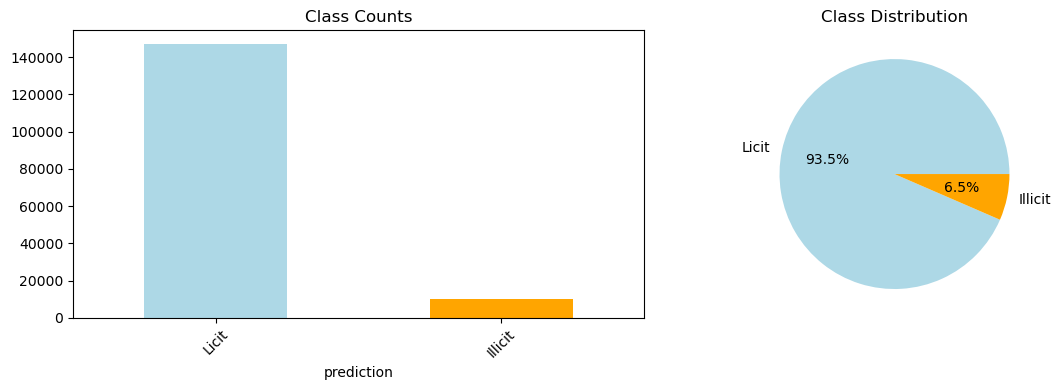

📊 Prediction Summary:
  Total predictions: 157,205
  Illicit transactions: 10,227
  Licit transactions: 146,978
  Imbalance ratio: 14.4:1

🔮 Sample illicit transactions (showing 100 of 10,227 total)
  Licit transactions: 146,978
  Imbalance ratio: 14.4:1

🔮 Sample illicit transactions (showing 100 of 10,227 total)


,txId,prediction
24,94251207,Illicit
40,3307463,Illicit
160,232894488,Illicit
502,79871665,Illicit
526,232432891,Illicit
...,...,...
6367,310445624,Illicit
6381,310475826,Illicit
6384,310529091,Illicit
6442,312199031,Illicit



🔮 Sample licit transactions (showing 100 of 146,978 total)


,txId,prediction
0,230425980,Licit
1,5530458,Licit
2,232022460,Licit
3,230460314,Licit
4,230459870,Licit
...,...,...
97,230521273,Licit
98,230658997,Licit
99,231179660,Licit
100,230967090,Licit


In [12]:
# Apply best model to unlabeled data
X_unlabeled = df_unlabeled.drop(['class', 'txId'], axis=1)
y_proba = best_model.predict_proba(X_unlabeled)[:, 1]
predictions = (y_proba >= optimal_threshold).astype(int)
df_prediction = pd.Series(predictions, name="prediction")
df_final = pd.concat([df_unlabeled[['txId']], df_prediction], axis=1)
df_final = df_final.applymap(lambda x: 'Illicit' if x == 0 else 'Licit' if x == 1 else x)

# Analyze prediction distribution
class_counts = df_final['prediction'].value_counts()
labeled_only = class_counts[class_counts.index != 'unknown']
imbalance_ratio = labeled_only.max() / labeled_only.min() if len(labeled_only) >= 2 else 1.0

# Plot distribution
print(f"\n📈 Prediction Distribution:")
print(f"Model used:", best_model_name)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
class_counts.plot(kind='bar', ax=ax1, color=['lightblue', 'orange', 'lightcoral'])
ax1.set_title('Class Counts')
ax1.tick_params(axis='x', rotation=45)
class_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', colors=['lightblue', 'orange', 'lightcoral'])
ax2.set_title('Class Distribution')
ax2.set_ylabel('')
plt.tight_layout()
plt.show()

# Display prediction samples and summary statistics
print(f"📊 Prediction Summary:")
print(f"  Total predictions: {len(df_final):,}")
print(f"  Illicit transactions: {sum(df_final['prediction'] == 'Illicit'):,}")
print(f"  Licit transactions: {sum(df_final['prediction'] == 'Licit'):,}")
print(f"  Imbalance ratio: {imbalance_ratio:.1f}:1")

# Get sample transactions for analysis
illicit_selector = df_final['prediction'] == 'Illicit'
X_unlabeled_illicit = df_final[illicit_selector].head(100)
print(f"\n🔮 Sample illicit transactions (showing {len(X_unlabeled_illicit)} of {sum(illicit_selector):,} total)")
display(X_unlabeled_illicit)

licit_selector = df_final['prediction'] == 'Licit'
X_unlabeled_licit = df_final[licit_selector].head(100)
print(f"\n🔮 Sample licit transactions (showing {len(X_unlabeled_licit)} of {sum(licit_selector):,} total)")
display(X_unlabeled_licit)

### Considerations

Some considerations must be made before the conclusion:

- Compressed data can increase training time but reduces dataset sizes without influencing the final result.

- Models like Naive Bayes reached almost 0.7427 in contrast to other models it was the worst performance;  

**Future improvements to training:**

- The unsupervised approach could produce good or even better results because it would use much more data to identify patterns by using the complete dataset. Also, the labeled dataset could indicate which clusters could be labeled with the illicit class;

- The training could use models more recommended for graph-type datasets, such as Graph Convolutional Networks (GCN), making use of the edge dataset to learn patterns with deeper transaction chains, not only direct neighbors.

**Production readiness:**

- This training was performed on a dataset curated for research purposes. There is no information about which features were used, so in order to have a production-ready model, a new dataset in the same format would need to be gathered and curated;

- A final performance indicator would need to be established to consider the model ready for a production environment, by classifying real labeled current data.

### Conclusions

#### Model Performance Summary

This supervised learning approach successfully developed a high-performance KYT system achieving **97.50% performance** on composite score when classifying cryptocurrencies transactions. The **TabNet** emerged as the champion model, demonstrating superior performance in distinguishing illicit from licit Bitcoin transactions, also minimizing the false positves and negatives.

#### Key Technical Conclusions

- **Dimensionality Reduction**: PCA preprocessing reduced feature space dimensions and TabNet's Internal Dimensionality Reduction
- **Algorithm Comparison**: Comprehensive evaluation of 20 ML algorithms with hyperparameter and tunning optimization via Bayesian Optimization ensured best performance findings
- **Model Ranking**: TabNet (97.50%) > FNN (96.44%) > Vote-Soft (96.28%) deep learning excels in financial pattern recognition followed by tradicional SVC and FNN combined
- **Pipeline Standardization**: StandardScaler + PCA + model architecture ensures consistent preprocessing across algorithms but the QuantileTransformer + TabNet excels
- **Model Persistence**: All trained models saved with compression for deployment scalability
- **Performance Validation**: Stratified cross-validation ensures reliable performance on imbalanced financial data assuming no pattern variation in time.

#### Real-World Impact

The trained model successfully processed **157,205.00 unlabeled transactions**, identifying **10,227.00 potentially illicit transactions**, providing risk assessment capabilities for unknown data—essential for AML compliance, that represents 6.5% of illicit transactions.